# Configuracao e inicializacao spark

In [1]:
import pyspark.sql.functions as F
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import findspark
findspark.init()

from pyspark.sql import SparkSession

from pyspark.sql.window import Window
from pyspark.ml.stat import Correlation, ChiSquareTest
from pyspark.ml.feature import StringIndexer, VectorAssembler

In [2]:
spark = (
    SparkSession.builder
    .appName("datamaster_case_gustavo")
    # Usar todos os cores locais disponíveis;
    .master("local[*]")
    # memória do driver (~70% da RAM total)
    .config("spark.driver.memory", "20g")
    # tamanho de partição padrão (OBS: ajustar depois baseado no tamanho final)
    .config("spark.sql.shuffle.partitions", "200")
    # compressão em disco
    .config("spark.sql.parquet.compression.codec", "snappy")
    # para evitar broadcast grande nos joins
    .config("spark.sql.autoBroadcastJoinThreshold", "50MB")
    .getOrCreate()
)

In [3]:
base_path = r"C:\Users\Gustavo\Downloads\datamaster\dados\parquet"  # ajuste para o seu caminho

df_logs = spark.read.parquet(f"{base_path}/user_logs.parquet")
df_transactions   = spark.read.parquet(f"{base_path}/transactions.parquet")
df_members  = spark.read.parquet(f"{base_path}/members.parquet")

# Funcoes Utilizadas

In [4]:
def verificar_duplicatas(df, col_id="msno", col_safra="safra", visualizar=False):
    """
    Identifica e conta linhas duplicadas para a mesma chave (ID + Safra).
    """
    # Define a janela abrangendo todas as linhas do grupo
    window_spec = Window.partitionBy(col_id, col_safra)\
                        .rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)
    
    # Adiciona contagem e filtra duplicados
    df_duplicados = df.withColumn("contagem_janela", F.count("*").over(window_spec)).filter("contagem_janela > 1")
    
    if visualizar:
        df_duplicados.show(10)
    
    # Retorna a quantidade total de linhas duplicadas encontradas
    return df_duplicados.count()

In [5]:
def verificar_mudanca_estado(df, col_alvo, col_id="msno", col_safra="safra", visualizar=False):
    """
    Verifica mudanças de estado em uma variável ao longo do tempo (safras).
    """
    # Definir a especificação da janela
    window_spec = Window.partitionBy(col_id).orderBy(col_safra)

    # Lag para criar as colunas de estado anterior da variavel e detecção de mudança
    df_historico = (
        df.withColumn(f"{col_alvo}_anterior", F.lag(col_alvo).over(window_spec))
          .withColumn("mudou", 
              F.when(F.col(f"{col_alvo}_anterior").isNull(), False)
               .otherwise(F.col(col_alvo) != F.col(f"{col_alvo}_anterior"))))

    # Caso o usuario deseje visualizar as mudancas
    if visualizar:
        # Filtra apenas onde houve mudança para facilitar a validação visual
        df_historico.filter(F.col("mudou") == True).show(10)

    # 4. Retornar a contagem de mudanças
    return df_historico.filter(F.col("mudou") == True).count()

In [6]:
def calcular_distribuicao(df, coluna_alvo, total_base, col_id="msno", n_show=10):
    """
    Gera agregação de contagem e percentual sobre uma variável alvo.
    """
    df_result = df.groupBy(coluna_alvo).agg(
        F.count(col_id).alias("total"),
        F.round((F.count(col_id) / F.lit(total_base)) * 100, 2).alias("pct_total")
    ).orderBy(F.desc("total"))
    
    df_result.show(n_show)

In [6]:
def analise_correlacao_quantitativa(df, colunas, plot=True):
    """
    df: Spark DataFrame
    colunas: Lista com nomes das colunas numéricas
    """
    n = len(colunas)
    
    # 1. Caso: Par de variáveis (Scatter Plot + Métricas)
    if n == 2:
        col1, col2 = colunas
        
        # Calculando correlações via Spark (Pearson e Spearman)
        pearson_val = df.corr(col1, col2, method="pearson")
        spearman_val = df.corr(col1, col2, method="spearman")
        
        print(f"Correlação de Pearson: {pearson_val:.4f}")
        print(f"Correlação de Spearman: {spearman_val:.4f}")

        if plot:
            # Para o gráfico, amostramos os dados (0.1% ou limite fixo) para não travar a memória
            # 30 milhões -> 30 mil pontos é suficiente para visualização
            amostra_pd = df.select(col1, col2).sample(False, fraction=min(1.0, 50000/df.count())).toPandas()
            
            plt.figure(figsize=(8, 6))
            sns.scatterplot(data=amostra_pd, x=col1, y=col2, alpha=0.5)
            plt.title(f"Dispersão: {col1} vs {col2}\n(Pearson: {pearson_val:.2f} | Spearman: {spearman_val:.2f})")
            plt.grid(True)
            # plt.savefig('scatter_plot.png')
            plt.show()
            plt.close()
        
    # 2. Caso: Matriz de correlação (> 2 variáveis)
    else:
        # Preparando o vetor para o Spark ML
        assembler = VectorAssembler(inputCols=colunas, outputCol="features", handleInvalid="skip")
        df_vector = assembler.transform(df).select("features")
        
        def get_corr_matrix(method):
            matrix = Correlation.corr(df_vector, "features", method=method).collect()[0][0]
            return pd.DataFrame(matrix.toArray(), index=colunas, columns=colunas)
        
        matrix_pearson = get_corr_matrix("pearson")
        matrix_spearman = get_corr_matrix("spearman")
        
        if plot:
            # Plotando as duas matrizes
            fig, ax = plt.subplots(1, 2, figsize=(16, 6))
            sns.heatmap(matrix_pearson, annot=True, fmt=".2f", cmap='coolwarm', ax=ax[0])
            ax[0].set_title("Matriz de Pearson")
            
            sns.heatmap(matrix_spearman, annot=True, fmt=".2f", cmap='viridis', ax=ax[1])
            ax[1].set_title("Matriz de Spearman")
            
            plt.tight_layout()
            # plt.savefig('correlation_matrices.png')
            plt.show()
            plt.close()
        
        return matrix_pearson, matrix_spearman

# Exemplo de uso:
# analise_correlacao_quantitativa(spark_df, ['idade', 'renda', 'score'])

In [7]:
def calcular_cramer_v_spark(df, col1, col2):
    """
    Calcula o V de Cramer de forma distribuída no Spark.
    """
    # Indexar colunas (necessário para o ChiSquareTest do Spark)
    # Nota: Para performance, se as colunas já forem numéricas/categorias indexadas, pule esta etapa.
    indexer1 = StringIndexer(inputCol=col1, outputCol="idx1", handleInvalid="skip")
    indexer2 = StringIndexer(inputCol=col2, outputCol="idx2", handleInvalid="skip")
    
    indexed_df = indexer1.fit(df).transform(df)
    indexed_df = indexer2.fit(indexed_df).transform(indexed_df)
    
    # Criar vetor de features para o teste
    assembler = VectorAssembler(inputCols=["idx1"], outputCol="features")
    test_data = assembler.transform(indexed_df).select("idx2", "features")
    
    # Chi-Square Test
    # idx2 é o 'label', features (idx1) é o atributo
    res = ChiSquareTest.test(test_data, "features", "idx2").head()
    chi2 = float(res.pValues.indices[0]) # No Spark 3.x, o retorno pode variar levemente conforme a versão
    # Alternativa mais robusta para pegar o statistic:
    chi2 = float(res.statistics[0])
    
    # Parâmetros para Cramer's V
    n = df.count()
    r = df.select(col1).distinct().count()
    k = df.select(col2).distinct().count()
    
    if n <= 1: return 0.0
    
    # Cálculo do Cramer's V (versão simples para estabilidade em Spark)
    v = np.sqrt(chi2 / (n * min(r-1, k-1)))
    return v

def plot_cramer_spark(df, coluna_interesse, colunas_categoricas):
    """
    df: Spark DataFrame
    coluna_interesse: A variável alvo qualitativa
    colunas_categoricas: Lista de outras colunas qualitativas para comparar
    """
    resultados = {}
    
    for col in colunas_categoricas:
        if col == coluna_interesse:
            continue
        try:
            v = calcular_cramer_v_spark(df, coluna_interesse, col)
            resultados[col] = v
            print(f"Cramer's V entre {coluna_interesse} e {col}: {v:.4f}")
        except Exception as e:
            print(f"Erro ao calcular para {col}: {e}")
            resultados[col] = np.nan

    # Preparar DataFrame para Plot
    cramer_df = pd.DataFrame([resultados], index=[coluna_interesse])
    
    plt.figure(figsize=(min(len(colunas_categoricas)*2, 15), 2))
    sns.heatmap(cramer_df, annot=True, fmt='.2f', cmap='YlGnBu')
    plt.title(f"Associação de Cramer's V com '{coluna_interesse}'")
    # plt.savefig('cramer_v_heatmap.png')
    plt.show()
    plt.close()
    
    # Top 5 relações
    top_5 = sorted(resultados.items(), key=lambda x: x[1] if not np.isnan(x[1]) else 0, reverse=True)[:5]
    print("\nTop 5 variáveis com maior associação:")
    for item in top_5:
        print(f"{item[0]}: {item[1]:.4f}")

# Exemplo de uso:
# plot_cramer_spark(spark_df, 'target_cat', ['regiao', 'canal_venda', 'segmento'])

In [26]:
def identificar_outliers(df, coluna, negativo=True):
    # Calcula os quantis de forma aproximada para performance
    quantis = df.approxQuantile(coluna, [0.25, 0.75], 0.05)
    q1, q3 = quantis[0], quantis[1]
    iqr = q3 - q1
    limite_superior = q3 + 1.5 * iqr
    
    # Se negativo for True, permite valores negativos no limite inferior --> dependendo da variável
    if negativo:
        limite_inferior = q1 - 1.5 * iqr
    else:
        limite_inferior = max(0, (q1 - 1.5 * iqr))
    
    outliers = df.filter((F.col(coluna) < limite_inferior) | (F.col(coluna) > limite_superior))
    print(f"Variável {coluna}:")
    print(f"Limites: [{limite_inferior}, {limite_superior}]")
    print(f"Total de outliers (#): {outliers.count()}")
    print(f"Total de outliers (%): {(outliers.count() / df.count()) * 100:.2f}%")

In [20]:
def plot_tendencia_temporal(df, col_valor, col_safra="safra"):
    # Agregação no Spark
    stats_safra = df.groupBy(col_safra).agg(F.mean(col_valor).alias("media")).orderBy(col_safra).toPandas()
    
    # CONVERSÃO: Tratar a safra como categoria (texto)
    stats_safra[col_safra] = stats_safra[col_safra].astype(str)
    
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=stats_safra, x=col_safra, y="media", marker='o', sort=False)
    plt.title(f"Evolução da média de {col_valor} por safra")
    plt.xticks(rotation=45)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [71]:
def integridade_entre_bases(df_base, df_comparacao, nome_relacao, chave=["msno", "safra"]):
    """
    Rastreia a perda de dados entre tabelas (ex: membros vs logs).
    Essencial para justificar a volumetria final do modelo.
    """
    total_base = df_base.select(chave).distinct().count()
    com_match = df_base.join(df_comparacao, chave, "inner").select(chave).distinct().count()
    perda = ((total_base - com_match) / total_base) * 100
    
    print(f"--- Integridade: {nome_relacao} ---")
    print(f"Registros na base: {total_base} | Registros correspondentes: {com_match}")
    print(f"Taxa de Perda: {perda:.2f}%\n")

# EDA

## Analise Especifica de Tabela: logs

### dictionary

Definition: daily user logs describing listening behaviors of a user. Data collected until 3/31/2017.

* msno: user id
* date: format %Y%m%d
* num_25: # of songs played less than 25% of the song 
length
* num_50: # of songs played between 25% to 50% of the 
song length
* num_75: # of songs played between 50% to 75% of of
the song length
* num_985: # of songs played between 75% to 98.5% of 
the song length
* num_100: # of songs played over 98.5% of the song 
length
* num_unq: # of unique songs played
* total_secs: total seconds played





### general info

In [10]:
total_logs = df_logs.count()
total_logs

26758971

In [11]:
df_logs.printSchema()

root
 |-- msno: string (nullable = true)
 |-- safra: integer (nullable = true)
 |-- num_25: double (nullable = true)
 |-- num_50: double (nullable = true)
 |-- num_75: double (nullable = true)
 |-- num_985: double (nullable = true)
 |-- num_100: double (nullable = true)
 |-- num_unq: double (nullable = true)
 |-- total_secs: double (nullable = true)



In [12]:
df_logs.groupBy("safra").count().orderBy("safra").show(5, truncate=False)

+------+------+
|safra |count |
+------+------+
|201501|937789|
|201502|933040|
|201503|944739|
|201504|939930|
|201505|924216|
+------+------+
only showing top 5 rows



In [13]:
df_logs.show(10, truncate=False)

+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+
|msno                                        |safra |num_25|num_50|num_75|num_985|num_100|num_unq|total_secs        |
+--------------------------------------------+------+------+------+------+-------+-------+-------+------------------+
|SwlrSivYHoKF9V5wm1YYYAnjHpd9y3OPjI9rDUhGJ3k=|201701|121.0 |28.0  |14.0  |29.0   |704.0  |827.0  |184606.903        |
|rE5wSmHEF1Dhu55zhkiGB1HvotdlSHcIMGXv6VcqO2A=|201605|26.0  |2.0   |5.0   |6.0    |462.0  |256.0  |119439.485        |
|hx+cyaQ/Jcdr/Z5foa/Cn0PXUzC/F7QO/NQvWQS1Qtc=|201611|161.0 |71.0  |49.0  |34.0   |668.0  |891.0  |204791.242        |
|53QW6B70J23X2UCvxaaUppjyE0b6X9nzP79W4huZv+Q=|201502|37.0  |9.0   |3.0   |9.0    |408.0  |447.0  |101186.041        |
|/0S1N/oRyxGLZlzxnW5rOjfo0ZAls9EH23ahuDNuqz8=|201506|205.0 |49.0  |23.0  |21.0   |225.0  |489.0  |69957.524         |
|qB/zteXKaOk3hzFCoIUD6wrTp57hnreDX4Vvon25MfM=|201509|52.

First assumptions:

* The variables "num_percent" are related to songs that can be REPEATED, which means, they only interfer in "num_unq" variable with the rule that their sum cannot be below num_unq --> it would not make sense since if we listen a new song we add another value to num_unq and add this one value in one of num_percent variables AND if we listen again to this song we DO NOT add in num_unq, BUT add in one of num_percent.

Feature Engineering: construir a variavel percentual de musicas finalizadas = num_100/sum(num_25, num_50, num_75, num_985)

#### Duplicatas e aparicoes

In [52]:
print("Número de duplicatas encontradas: " + str(verificar_duplicatas(df_logs)))

Número de duplicatas encontradas: 0


In [20]:
logs_contagem = df_logs.groupBy('msno').agg(F.count('*').alias('contagem'))
logs_contagem.select("contagem").summary("count", "mean", "stddev", "min", "25%", "50%", "75%", "99.5%", "max").show()

+-------+-----------------+
|summary|         contagem|
+-------+-----------------+
|  count|          5234111|
|   mean|5.112419472953477|
| stddev|7.579316644302186|
|    min|                1|
|    25%|                1|
|    50%|                1|
|    75%|                4|
|  99.5%|               26|
|    max|               26|
+-------+-----------------+



In [55]:
contagem_logs = logs_contagem.count()
calcular_distribuicao(logs_contagem, "contagem", contagem_logs, col_id="contagem")

+--------+-------+---------+
|contagem|  total|pct_total|
+--------+-------+---------+
|       1|2940775|    56.18|
|       2| 678146|    12.96|
|      26| 330373|     6.31|
|       3| 193813|      3.7|
|       4| 115104|      2.2|
|       5|  86369|     1.65|
|       6|  75191|     1.44|
|       7|  68650|     1.31|
|       8|  62998|      1.2|
|      13|  53738|     1.03|
+--------+-------+---------+
only showing top 10 rows



Aproximadamente 56% da base total aparece somente uma vez na base de logs.

In [15]:
contagem_safra_logs = df_logs.select("safra").distinct().count()
print(f"O número de safras na base é: {contagem_safra_logs}")

O número de safras na base é: 26


### num_25

In [25]:
df_logs.select("num_25").summary("count", "mean", "stddev", "min", "1%", "10%", "25%", "50%", "75%", "95%", "99.5%", "max").show()

+-------+------------------+
|summary|            num_25|
+-------+------------------+
|  count|          26758971|
|   mean| 95.42601163549973|
| stddev|175.28825956456888|
|    min|               0.0|
|     1%|               0.0|
|    10%|               2.0|
|    25%|               9.0|
|    50%|              40.0|
|    75%|             114.0|
|    95%|             369.0|
|  99.5%|             975.0|
|    max|          111864.0|
+-------+------------------+



In [13]:
percentage = (df_logs.filter(F.col("num_25") > 975).select("num_25").count() / total_logs) * 100
print(f"{percentage:.2f}% dos registros têm num_25 > 975")

0.50% dos registros têm num_25 > 975


In [27]:
identificar_outliers(df_logs, "num_25", negativo=False)

Variável num_25:
Limites: [0, 246.5]
Total de outliers (#): 2636926
Total de outliers (%): 9.85%


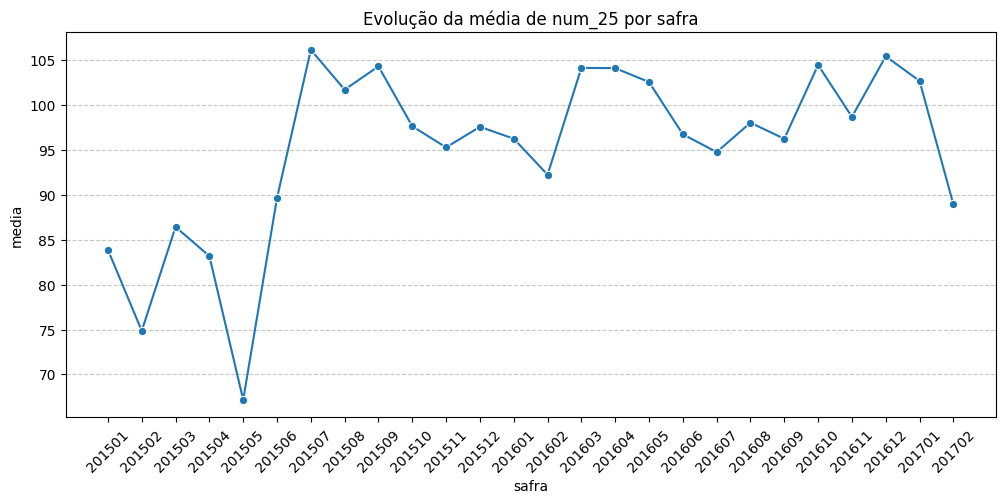

In [21]:
plot_tendencia_temporal(df_logs, col_valor="num_25", col_safra="safra")

### num_50

In [24]:
df_logs.select("num_50").summary("count", "mean", "stddev", "min", "1%", "10%", "25%", "50%", "75%", "95%", "99.5%", "max").show()

+-------+-----------------+
|summary|           num_50|
+-------+-----------------+
|  count|         26758971|
|   mean|24.03566975725636|
| stddev|39.12554591867814|
|    min|              0.0|
|     1%|              0.0|
|    10%|              0.0|
|    25%|              3.0|
|    50%|             11.0|
|    75%|             30.0|
|    95%|             89.0|
|  99.5%|            222.0|
|    max|           8875.0|
+-------+-----------------+



In [19]:
percentage = (df_logs.filter((F.col("num_50") > 30)).select("num_50").count() / total_logs) * 100
print(f"{percentage:.2f}% dos registros têm num_50 > 30")

24.81% dos registros têm num_50 > 30


In [30]:
percentage = (df_logs.filter((F.col("num_50").between(0, 30))).select("num_50").count() / total_logs) * 100
print(f"{percentage:.2f}% dos registros têm num_50 entre 0 e 30")

75.19% dos registros têm num_50 entre 0 e 30


In [18]:
percentage = (df_logs.filter((F.col("num_50").between(30, 100))).select("num_50").count() / total_logs) * 100
print(f"{percentage:.2f}% dos registros têm num_50 entre 30 e 100")

21.73% dos registros têm num_50 entre 30 e 100


In [31]:
percentage = (df_logs.filter((F.col("num_50").between(0, 100))).select("num_50").count() / total_logs) * 100
print(f"{percentage:.2f}% dos registros têm num_50 entre 0 e 100")

96.09% dos registros têm num_50 entre 0 e 100


In [23]:
percentage = (df_logs.filter(F.col("num_50") > 222).select("num_50").count() / total_logs) * 100
print(f"{percentage:.2f}% dos registros têm num_50 > 222")

0.50% dos registros têm num_50 > 222


In [28]:
identificar_outliers(df_logs, "num_50", negativo=False)

Variável num_50:
Limites: [0, 68.0]
Total de outliers (#): 2215100
Total de outliers (%): 8.28%


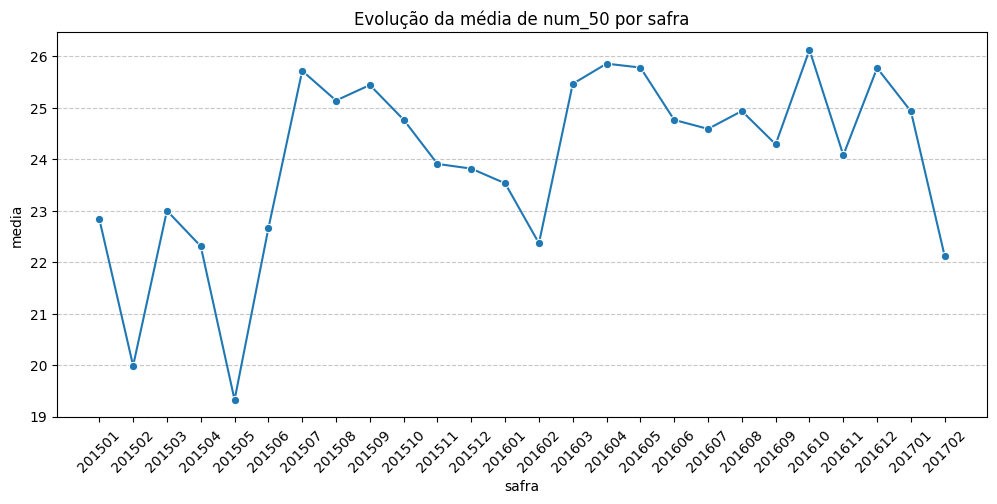

In [29]:
plot_tendencia_temporal(df_logs, col_valor="num_50", col_safra="safra")

### num_75

In [26]:
df_logs.select("num_75").summary("count", "mean", "stddev", "min", "1%", "10%", "25%", "50%", "75%", "95%", "99.5%", "max").show()

+-------+------------------+
|summary|            num_75|
+-------+------------------+
|  count|          26758971|
|   mean|14.903521327483034|
| stddev| 22.62672151325168|
|    min|               0.0|
|     1%|               0.0|
|    10%|               0.0|
|    25%|               2.0|
|    50%|               7.0|
|    75%|              20.0|
|    95%|              54.0|
|  99.5%|             127.0|
|    max|            3485.0|
+-------+------------------+



In [28]:
percentage = (df_logs.filter((F.col("num_75").between(0, 100))).select("num_75").count() / total_logs) * 100
print(f"{percentage:.2f}% dos registros têm num_75 entre 0 e 100")

98.99% dos registros têm num_75 entre 0 e 100


In [29]:
percentage = (df_logs.filter(F.col("num_75") > 127).select("num_75").count() / total_logs) * 100
print(f"{percentage:.2f}% dos registros têm num_75 > 127")

0.49% dos registros têm num_75 > 127


In [30]:
identificar_outliers(df_logs, "num_75", negativo=False)

Variável num_75:
Limites: [0, 42.0]
Total de outliers (#): 2208148
Total de outliers (%): 8.25%


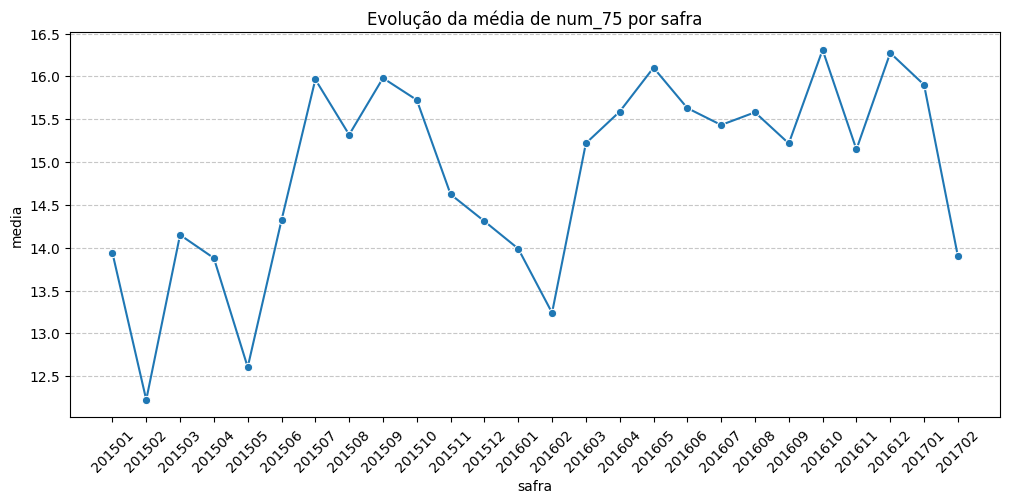

In [31]:
plot_tendencia_temporal(df_logs, col_valor="num_75", col_safra="safra")

### num_985

In [32]:
df_logs.select("num_985").summary("count", "mean", "stddev", "min", "1%", "10%", "25%", "50%", "75%", "95%", "99.5%", "max").show()

+-------+------------------+
|summary|           num_985|
+-------+------------------+
|  count|          26758971|
|   mean|16.538671797207748|
| stddev|37.409156681476375|
|    min|               0.0|
|     1%|               0.0|
|    10%|               0.0|
|    25%|               1.0|
|    50%|               7.0|
|    75%|              20.0|
|    95%|              60.0|
|  99.5%|             164.0|
|    max|           37698.0|
+-------+------------------+



In [33]:
percentage = (df_logs.filter((F.col("num_985").between(0, 100))).select("num_985").count() / total_logs) * 100
print(f"{percentage:.2f}% dos registros têm num_985 entre 0 e 100")

98.38% dos registros têm num_985 entre 0 e 100


In [34]:
percentage = (df_logs.filter(F.col("num_985") > 164).select("num_985").count() / total_logs) * 100
print(f"{percentage:.2f}% dos registros têm num_985 > 127")

0.49% dos registros têm num_985 > 127


In [32]:
identificar_outliers(df_logs, "num_985", negativo=False)

Variável num_985:
Limites: [0, 44.5]
Total de outliers (#): 2339963
Total de outliers (%): 8.74%


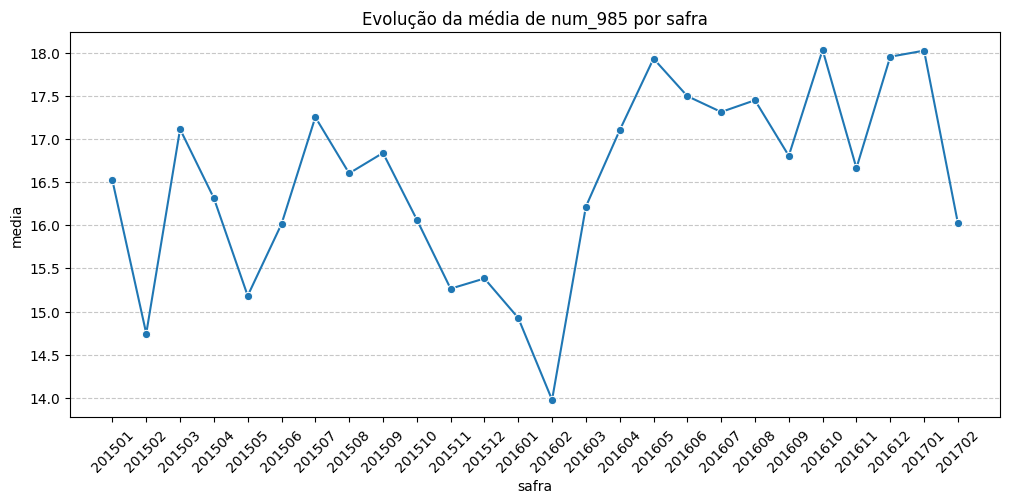

In [33]:
plot_tendencia_temporal(df_logs, col_valor="num_985", col_safra="safra")

### num_100

In [35]:
df_logs.select("num_100").summary("count", "mean", "stddev", "min", "1%", "10%", "25%", "50%", "75%", "95%", "99.5%", "max").show()

+-------+-----------------+
|summary|          num_100|
+-------+-----------------+
|  count|         26758971|
|   mean|450.1598216538297|
| stddev|725.3139035411615|
|    min|              0.0|
|     1%|              0.0|
|    10%|              2.0|
|    25%|             37.0|
|    50%|            211.0|
|    75%|            564.0|
|    95%|           1697.0|
|  99.5%|           4365.0|
|    max|         196741.0|
+-------+-----------------+



In [37]:
percentage = (df_logs.filter((F.col("num_100").between(0, 1700))).select("num_100").count() / total_logs) * 100
print(f"{percentage:.2f}% dos registros têm num_100 entre 0 e 1700")

95.02% dos registros têm num_100 entre 0 e 1700


In [39]:
percentage = (df_logs.filter(F.col("num_100") > 4365).select("num_100").count() / total_logs) * 100
print(f"{percentage:.2f}% dos registros têm num_100 > 4365")

0.50% dos registros têm num_100 > 4365


In [34]:
identificar_outliers(df_logs, "num_100", negativo=False)

Variável num_100:
Limites: [0, 1277.5]
Total de outliers (#): 2190020
Total de outliers (%): 8.18%


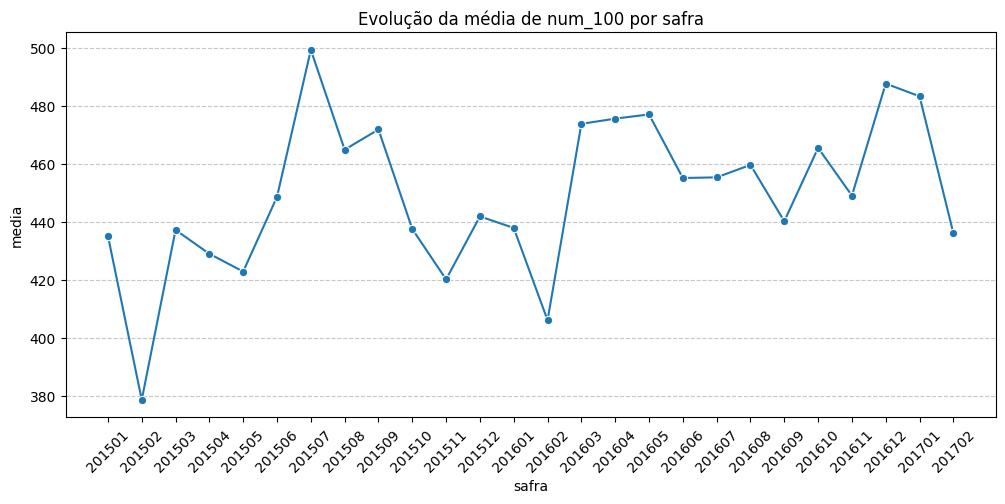

In [35]:
plot_tendencia_temporal(df_logs, col_valor="num_100", col_safra="safra")

### num_unq

In [40]:
df_logs.select("num_unq").summary("count", "mean", "stddev", "min", "1%", "10%", "25%", "50%", "75%", "95%", "99.5%", "max").show()

+-------+------------------+
|summary|           num_unq|
+-------+------------------+
|  count|          26758971|
|   mean|440.91930526775485|
| stddev| 590.6059571748677|
|    min|               1.0|
|     1%|               1.0|
|    10%|               7.0|
|    25%|              50.0|
|    50%|             239.0|
|    75%|             600.0|
|    95%|            1559.0|
|  99.5%|            3398.0|
|    max|           32706.0|
+-------+------------------+



In [42]:
percentage = (df_logs.filter((F.col("num_unq").between(0, 3400))).select("num_unq").count() / total_logs) * 100
print(f"{percentage:.2f}% dos registros têm num_unq entre 0 e 3400")

99.50% dos registros têm num_unq entre 0 e 3400


In [43]:
percentage = (df_logs.filter(F.col("num_unq") > 3398).select("num_unq").count() / total_logs) * 100
print(f"{percentage:.2f}% dos registros têm num_unq > 3398")

0.50% dos registros têm num_unq > 3398


In [36]:
identificar_outliers(df_logs, "num_unq", negativo=False)

Variável num_unq:
Limites: [0, 1345.5]
Total de outliers (#): 1842121
Total de outliers (%): 6.88%


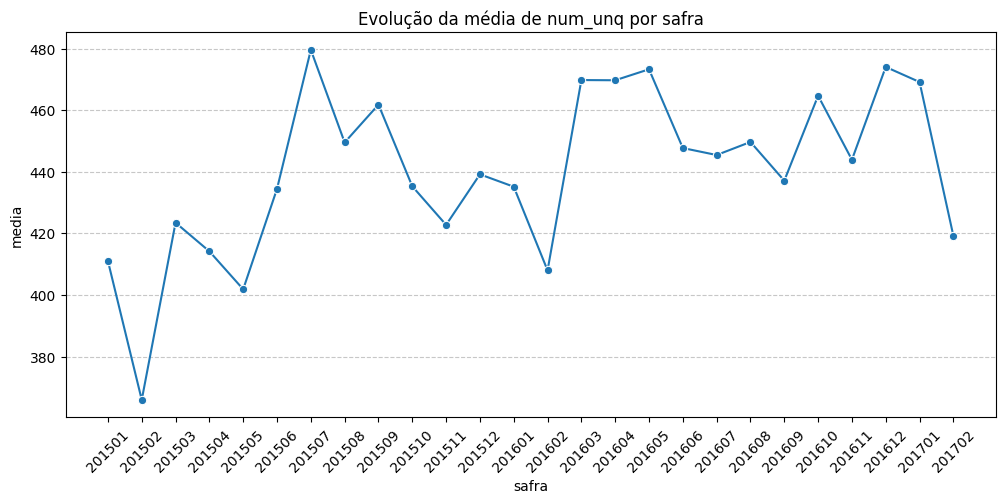

In [37]:
plot_tendencia_temporal(df_logs, col_valor="num_unq", col_safra="safra")

### total_secs

In [44]:
df_logs.select("total_secs").summary("count", "mean", "stddev", "min", "1%", "10%", "25%", "50%", "75%", "95%", "99.5%", "max").show()

+-------+--------------------+
|summary|          total_secs|
+-------+--------------------+
|  count|            26758971|
|   mean|-2.11717488634759...|
| stddev|6.839043702349422E14|
|    min|-2.39807672957245...|
|     1%|              28.797|
|    10%|             1041.48|
|    25%|           11021.553|
|    50%|  58359.429000000004|
|    75%|          152111.487|
|    95%|          441495.728|
|  99.5%|  1072298.1889999998|
|    max|9.223372037135594E15|
+-------+--------------------+



In [46]:
percentage = (df_logs.filter((F.col("total_secs") < 0)).select("total_secs").count() / total_logs) * 100
print(f"{percentage:.2f}% dos registros têm total_secs menor do que 0")

0.16% dos registros têm total_secs menor do que 0


In [45]:
df_logs.filter(F.col("total_secs") > 0).select("total_secs").summary("count", "mean", "stddev", "min", "1%", "10%", "25%", "50%", "75%", "95%", "99.5%", "max").show()

+-------+--------------------+
|summary|          total_secs|
+-------+--------------------+
|  count|            26716625|
|   mean|1.596254162738099...|
| stddev|1.210745784107657...|
|    min|               0.001|
|     1%|              35.082|
|    10%|            1069.775|
|    25%|  11162.853000000001|
|    50%|   58566.95500000001|
|    75%|          152332.517|
|    95%|          441852.025|
|  99.5%|  1072298.1889999998|
|    max|9.223372037135594E15|
+-------+--------------------+



In [38]:
identificar_outliers(df_logs, "total_secs", negativo=False)

Variável total_secs:
Limites: [0, 344114.68700000003]
Total de outliers (#): 2146972
Total de outliers (%): 8.02%


In [42]:
(344114/(60*60*24)) # conversão para dias

3.982800925925926

OBS: Depois de verificar correlacao entre as variaveis, seria interessante levantar o seguinte ponto para feature_store: ver qual o valor de num_percent maior e atribuir um peso em cima dessas categorias.

In [46]:
df_logs = df_logs.withColumn("total_days", F.col("total_secs") / (60*60*24))

In [50]:
df_logs.select("total_days").summary("count", "mean", "stddev", "min", "1%", "10%", "25%", "50%", "75%", "95%", "99.5%", "max").show(truncate=False)

+-------+---------------------+
|summary|total_days           |
+-------+---------------------+
|count  |26758971             |
|mean   |-2.4504338962349823E8|
|stddev |7.915559840682272E9  |
|min    |-2.775551770338489E12|
|1%     |3.3329861111111114E-4|
|10%    |0.012054166666666666 |
|25%    |0.12756427083333333  |
|50%    |0.6754563541666667   |
|75%    |1.7605496180555555   |
|95%    |5.10990425925926     |
|99.5%  |12.41085866898148    |
|max    |1.0675199117055086E11|
+-------+---------------------+



In [48]:
identificar_outliers(df_logs, "total_days", negativo=False)

Variável total_days:
Limites: [0, 3.982808877314815]
Total de outliers (#): 2146972
Total de outliers (%): 8.02%


In [51]:
percentage = (df_logs.filter((F.col("total_days").between(0, 15))).select("total_days").count() / total_logs) * 100
print(f"{percentage:.2f}% dos registros têm total_days entre 0 e 15")

99.64% dos registros têm total_days entre 0 e 15


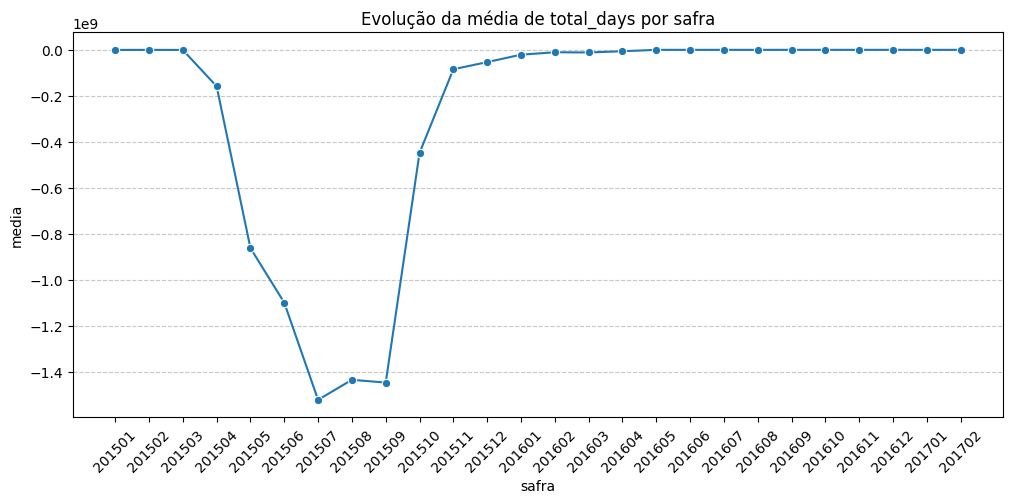

In [52]:
plot_tendencia_temporal(df_logs, col_valor="total_days", col_safra="safra")

## Analise Especifica de Tabela: transactions

### dictionary

Definition: transactions of users up until 3/31/2017.

* msno: user id
* payment_method_id: payment method
* payment_plan_days: length of membership plan in days
* plan_list_price: in New Taiwan Dollar (NTD)
* actual_amount_paid: in New Taiwan Dollar 
(NTD)
* is_auto_renew: automatic renovation on/off
* transaction_date: format %Y%m%d
* membership_expire_date: format %Y%m%d
* is_cancel: whether or not the user canceled the 
membership in this transaction.



### general info

In [53]:
df_transactions.count()

20712225

In [54]:
df_transactions.printSchema()

root
 |-- msno: string (nullable = true)
 |-- payment_method_id: string (nullable = true)
 |-- payment_plan_days: string (nullable = true)
 |-- plan_list_price: string (nullable = true)
 |-- actual_amount_paid: string (nullable = true)
 |-- is_auto_renew: string (nullable = true)
 |-- transaction_date: string (nullable = true)
 |-- membership_expire_date: string (nullable = true)
 |-- is_cancel: string (nullable = true)
 |-- safra: integer (nullable = true)



In [55]:
df_transactions.show(10, truncate=False)

+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|msno                                        |payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|safra |
+--------------------------------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+------+
|+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=|38               |410              |1788           |1788              |0            |20151121        |20170104              |0        |201511|
|+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=|41               |30               |149            |149               |1            |20150526        |20150626              |0        |201505|
|+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=|41       

#### Duplicatas e aparicoes

In [56]:
print("Número de duplicatas encontradas: " + str(verificar_duplicatas(df_transactions)))

Número de duplicatas encontradas: 0


In [25]:
trans_contagem = df_transactions.groupBy('msno').agg(F.count('*').alias('contagem'))
trans_contagem.select("contagem").summary("count", "mean", "stddev", "min", "25%", "50%", "75%", "99.5%", "max").show()

+-------+-----------------+
|summary|         contagem|
+-------+-----------------+
|  count|          2363626|
|   mean|8.762902845035551|
| stddev|8.580922690781978|
|    min|                1|
|    25%|                1|
|    50%|                5|
|    75%|               15|
|  99.5%|               26|
|    max|               26|
+-------+-----------------+



In [57]:
contagem_trans = trans_contagem.count()
calcular_distribuicao(trans_contagem, "contagem", contagem_trans, col_id="contagem")

+--------+------+---------+
|contagem| total|pct_total|
+--------+------+---------+
|       1|665663|    28.16|
|       2|313299|    13.26|
|      26|182281|     7.71|
|       3|112866|     4.78|
|       4| 80113|     3.39|
|      19| 79431|     3.36|
|      14| 65923|     2.79|
|      22| 64390|     2.72|
|       8| 63216|     2.67|
|       5| 61995|     2.62|
+--------+------+---------+
only showing top 10 rows



In [27]:
contagem_safra_trans = df_transactions.select("safra").distinct().count()
print(f"O número de safras na base é: {contagem_safra_trans}")

O número de safras na base é: 26


### plan_list_price + actual_amount_paid

In [16]:
df_transactions.groupBy("plan_list_price", "actual_amount_paid").count().orderBy(F.desc("count")).show(40)

+---------------+------------------+--------+
|plan_list_price|actual_amount_paid|   count|
+---------------+------------------+--------+
|            149|               149|11233604|
|             99|                99| 4774736|
|            129|               129| 1096720|
|              0|               149|  764403|
|            180|               180|  656705|
|              0|                 0|  562167|
|            149|                 0|  484549|
|            150|               150|  360929|
|            149|               119|  270324|
|            894|               894|  107881|
|           1788|              1788|   78940|
|            100|               100|   75569|
|            536|               536|   42850|
|            119|               119|   29195|
|              0|               129|   25410|
|              0|               119|   23335|
|            480|               480|   22736|
|              0|               150|   12462|
|           1599|              159

Nem tudo o que deveriam pagar foi efetivamente pago em alguns casos, bem como aparentemente houveram pagamentos que nao deveriam ter sido executados.

In [59]:
df_transactions_payment_diff = df_transactions.withColumn("payment_diff", F.col("actual_amount_paid") - F.col("plan_list_price"))
df_transactions_payment_diff = df_transactions_payment_diff.withColumn("flag_pag_diff", F.when(F.col("payment_diff") != 0, 1).otherwise(0))

In [62]:
percentage = df_transactions_payment_diff.filter(F.col("flag_pag_diff") == 1).count() / df_transactions_payment_diff.count() * 100
print(f"{percentage:.2f}% dos registros têm divergência no pagamento.")

7.71% dos registros têm divergência no pagamento.


In [68]:
df_transactions_payment_diff.filter(F.col("safra").between(201601, 201612)).groupBy("safra", "flag_pag_diff").count().orderBy("safra", "flag_pag_diff").show(24)

+------+-------------+-------+
| safra|flag_pag_diff|  count|
+------+-------------+-------+
|201601|            0| 810857|
|201601|            1|  45859|
|201602|            0| 767444|
|201602|            1|  24856|
|201603|            0| 754395|
|201603|            1|  21074|
|201604|            0| 753535|
|201604|            1|  20634|
|201605|            0| 766440|
|201605|            1|  17516|
|201606|            0| 791680|
|201606|            1|  13049|
|201607|            0| 914446|
|201607|            1|   9586|
|201608|            0| 960079|
|201608|            1|   6371|
|201609|            0| 978356|
|201609|            1|   4284|
|201610|            0|1030687|
|201610|            1|   3211|
|201611|            0|1091882|
|201611|            1|   3059|
|201612|            0| 966029|
|201612|            1|   2518|
+------+-------------+-------+



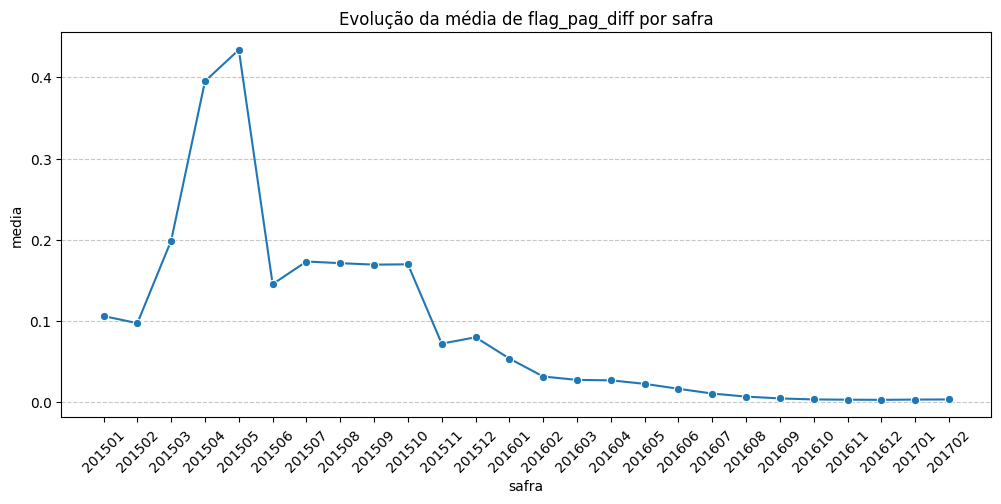

In [69]:
plot_tendencia_temporal(df_transactions_payment_diff, col_valor="flag_pag_diff", col_safra="safra")

### payment_method_id

In [10]:
df_transactions.groupBy("payment_method_id").count().orderBy(F.desc("count")).show(40)

+-----------------+--------+
|payment_method_id|   count|
+-----------------+--------+
|               41|11026911|
|               40| 2160126|
|               38| 1618337|
|               39| 1437059|
|               37|  991185|
|               36|  816661|
|               34|  728384|
|               35|  492261|
|               33|  402388|
|               31|  248960|
|               30|  150972|
|               32|  144037|
|               29|  108713|
|               28|   92752|
|               27|   60532|
|               23|   40594|
|               19|   32045|
|               20|   27977|
|               21|   22839|
|               22|   19973|
|               18|   15709|
|               14|   13591|
|               24|   12620|
|               25|   11741|
|               16|   10301|
|               13|    6305|
|               17|    5081|
|               12|    3796|
|               26|    2795|
|               11|    2114|
|               15|    1464|
|             

In [15]:
df_transactions.filter(F.col("payment_plan_days").isin(30, 31)).groupBy("payment_method_id", "plan_list_price", "payment_plan_days").count().orderBy(F.desc("count")).show(100)

+-----------------+---------------+-----------------+-------+
|payment_method_id|plan_list_price|payment_plan_days|  count|
+-----------------+---------------+-----------------+-------+
|               41|            149|               30|4909578|
|               41|             99|               30|4774736|
|               40|            149|               30|1749344|
|               38|            149|               30|1410136|
|               39|            149|               30|1132316|
|               41|            129|               30|1052734|
|               37|            149|               30| 819419|
|               36|            180|               30| 548264|
|               34|            149|               30| 514645|
|               40|            149|               31| 347336|
|               33|            149|               30| 279289|
|               36|            150|               30| 260519|
|               39|            149|               31| 229024|
|       

### is_cancel

In [4]:
df_transactions.groupBy("is_cancel").count().show()

+---------+--------+
|is_cancel|   count|
+---------+--------+
|        0|20031271|
|        1|  680954|
+---------+--------+



### payment_plan_days

In [ ]:
df_transactions.groupBy("payment_plan_days").count().orderBy(F.desc("count")).show()

+-----------------+--------+
|payment_plan_days|   count|
+-----------------+--------+
|               30|18251936|
|                0|  848204|
|               31|  743859|
|                7|  517635|
|              195|  107816|
|              410|   78425|
|              180|   51019|
|              100|   23828|
|               10|   22538|
|               90|   11518|
|              395|   10351|
|              120|    9882|
|               60|    6460|
|               14|    6111|
|              200|    5742|
|              360|    5275|
|                1|    2875|
|              400|    1791|
|              450|    1238|
|               45|    1081|
+-----------------+--------+
only showing top 20 rows



In [32]:
print("Publico com pacote de assinatura mensal:", str(df_transactions.filter(F.col("payment_plan_days").isin(30, 31)).count()))
print("Representatividade (%) do publico total:", (df_transactions.filter(F.col("payment_plan_days").isin(30, 31)).count() / df_transactions.count()) * 100)

Publico com pacote de assinatura mensal: 18995795
Representatividade (%) do publico total: 91.71296178947458


In [30]:
print("Publico com pacote de assinatura inferior ao mensal:", str(df_transactions.filter(F.col("payment_plan_days") < 30).count()))
print("Representatividade (%) do publico total:", (df_transactions.filter(F.col("payment_plan_days") < 30).count() / df_transactions.count()) * 100)

Publico com pacote de assinatura inferior ao mensal: 1398223
Representatividade (%) do publico total: 6.750713648581937


In [ ]:
print("Publico com pacote de assinatura superior ao mensal:", str(df_transactions.filter(F.col("payment_plan_days") > 31).count()))
print("Representatividade (%) do publico total:", str((df_transactions.filter(F.col("payment_plan_days") > 31).count() / df_transactions.count()) * 100))

Publico com pacote de assinatura superior ao mensal: 318207
Representatividade (%) do publico total: 1.5363245619434898


In [20]:
91.71296178947458 + 6.750713648581937 + 1.5363245619434898

100.0

Ideia, verificar se faz sentido -> Construir tres publicos para o modelo: menor de 1 mes, mensal e longa data

Aspecto pra verificar: o cara mantem permanentemente o tipo de pagamento em dias, ou altera ao longo da permanencia dele na base?

In [10]:
df_transactions.filter(F.col("msno").isin("+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=")).select("safra", "payment_plan_days").orderBy("safra").show(10)

+------+-----------------+
| safra|payment_plan_days|
+------+-----------------+
|201501|               30|
|201502|               30|
|201503|               30|
|201504|                0|
|201505|               30|
|201506|               30|
|201507|               30|
|201508|               30|
|201509|               30|
|201510|               30|
+------+-----------------+
only showing top 10 rows



### actual_amount_paid

In [5]:
df_transactions = df_transactions.withColumn("actual_amount_paid", F.col("actual_amount_paid").cast("float"))

In [6]:
df_transactions.select("actual_amount_paid").summary("count", "mean", "stddev", "min", "25%", "50%", "75%", "max").show()

+-------+------------------+
|summary|actual_amount_paid|
+-------+------------------+
|  count|          20712225|
|   mean|142.83468555406287|
| stddev|133.60944276809502|
|    min|               0.0|
|    25%|              99.0|
|    50%|             149.0|
|    75%|             149.0|
|    max|            2000.0|
+-------+------------------+



In [7]:
df_transactions.groupBy("actual_amount_paid").count().orderBy(F.desc("actual_amount_paid")).show()

+------------------+------+
|actual_amount_paid| count|
+------------------+------+
|            2000.0|   119|
|            1825.0|     2|
|            1802.0|     1|
|            1800.0|     1|
|            1799.0|     1|
|            1788.0| 82809|
|            1599.0| 11991|
|            1520.0|    13|
|            1200.0|  5313|
|            1150.0|    95|
|            1000.0|   741|
|             930.0|  5063|
|             894.0|111410|
|             890.0|     1|
|             849.0|     1|
|             800.0|    11|
|             799.0|  6422|
|             760.0|     2|
|             699.0|   887|
|             600.0|     3|
+------------------+------+
only showing top 20 rows



In [13]:
((df_transactions.filter(F.col("actual_amount_paid") > 149).count()) / (df_transactions.count())) * 100

6.521515674921454

Por representar aproximadamente 6,5% do total de transacoes, talvez faca sentido considerar como ponto de alavancagem e remover?

PENDENTE: aplicar a formula para capturar casos de alavancagem e ver se a quantidade diminui. O filtro atual considera apenas o valor mais comum ate 75% dos dados ordenados.

## Analise Especifica de Tabela: members

### dictionary

Definition: User information. Note that not every user in the dataset is available.

* msno
* city
* bd: age. Note: this column has outlier values ranging 
from -7000 to 2015, please use your judgement.
* gender
* registered_via: registration method
* registration_init_time: format %Y%m%d




### general info

In [4]:
total_members = df_members.count()
total_members

63867246

In [11]:
df_members.printSchema()

root
 |-- msno: string (nullable = true)
 |-- safra: string (nullable = true)
 |-- registration_init_time: string (nullable = true)
 |-- city: string (nullable = true)
 |-- bd: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- registered_via: string (nullable = true)
 |-- is_ativo: integer (nullable = true)



In [11]:
df_members.show(10, truncate=False)

+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+
|msno                                        |safra |registration_init_time|city|bd |gender|registered_via|is_ativo|
+--------------------------------------------+------+----------------------+----+---+------+--------------+--------+
|+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=|201612|20140927              |1   |0  |NULL  |7             |1       |
|++/AwGzubug3gT6J+0STBGMdWKxaM+UFZTI8Tcmq4To=|201607|20150322              |1   |0  |NULL  |9             |0       |
|++/Gw1B9K+XOlB3hLTloeUK2QlCa2m+BJ8TrzGf7djI=|201601|20121217              |15  |32 |male  |3             |1       |
|++02XbtviomSxcIBUHMOiJkjRxdicTXSfiVqLdsr5lo=|201603|20131112              |14  |21 |male  |7             |0       |
|++0O0Bq04sB/9ZcOS+pajpYL2Hin9jCqnc/8bKzKFuE=|201610|20141021              |5   |33 |male  |3             |0       |
|++2AQgVgYUAqJDw684tbDqDffUeKhqydyQmbr8lz9lQ=|201608|20150416   

#### Duplicatas e aparicoes

In [46]:
print("Número de duplicatas encontradas: " + str(verificar_duplicatas(df_members)))

Número de duplicatas encontradas: 0


In [28]:
members_contagem = df_members.groupBy('msno').agg(F.count('*').alias('contagem'))
members_contagem.select("contagem").summary("count", "mean", "stddev", "min", "25%", "50%", "75%", "99.5%", "max").show()

+-------+------------------+
|summary|          contagem|
+-------+------------------+
|  count|           6287789|
|   mean|10.157345610674913|
| stddev| 3.242783103114158|
|    min|                 1|
|    25%|                 9|
|    50%|                12|
|    75%|                12|
|  99.5%|                12|
|    max|                12|
+-------+------------------+



In [51]:
contagem_members = members_contagem.count()
calcular_distribuicao(members_contagem, "contagem", contagem_members, col_id="contagem", n_show=20)

+--------+-------+---------+
|contagem|  total|pct_total|
+--------+-------+---------+
|      12|4294184|    68.29|
|      11| 208170|     3.31|
|      10| 195618|     3.11|
|       7| 189359|     3.01|
|       6| 189273|     3.01|
|       8| 184404|     2.93|
|       9| 178329|     2.84|
|       5| 176584|     2.81|
|       1| 173444|     2.76|
|       3| 170302|     2.71|
|       2| 165057|     2.63|
|       4| 163065|     2.59|
+--------+-------+---------+



In [30]:
contagem_safra_members = df_members.select("safra").distinct().count()
print(f"O número de safras na base é: {contagem_safra_members}")

O número de safras na base é: 12


### tipagem

In [6]:
df_members = (df_members
              .withColumn("bd", F.col("bd").cast("integer"))
              .withColumn("is_ativo", F.col("is_ativo").cast("integer"))
              .withColumn("registered_via", F.col("registered_via").cast("integer")))

### registered_via

In [7]:
df_members.groupBy("registered_via").agg(
    F.count("msno").alias("total_members"),
    F.round((F.count("msno") / F.lit(total_members)) * 100, 2).alias("pct_total")
).orderBy(F.desc("total_members")).show(50)

+--------------+-------------+---------+
|registered_via|total_members|pct_total|
+--------------+-------------+---------+
|             4|     19648219|    30.76|
|             3|     18640987|    29.19|
|             9|     16776651|    26.27|
|             7|      8407395|    13.16|
|            11|       269614|     0.42|
|             8|        47588|     0.07|
|             5|        18715|     0.03|
|             2|        16847|     0.03|
|            16|        10564|     0.02|
|            13|         7546|     0.01|
|            14|         7111|     0.01|
|            17|         6630|     0.01|
|            19|         5629|     0.01|
|             6|         3380|     0.01|
|             1|          254|      0.0|
|            10|          104|      0.0|
|            -1|           12|      0.0|
+--------------+-------------+---------+



Me parece uma boa ideia agrupar o 7 com todos os demais.

In [8]:
df_members = df_members.withColumn("registered_via_new",
    F.when(F.col("registered_via").isin(4), F.col("registered_via"))\
    .when(F.col("registered_via").isin(3), F.col("registered_via"))\
    .when(F.col("registered_via").isin(9), F.col("registered_via"))\
    .otherwise(F.lit("Outros")))

df_members.groupBy("registered_via_new").agg(
    F.count("msno").alias("total_members"),
    F.round((F.count("msno") / F.lit(total_members)) * 100, 2).alias("pct_total")
).orderBy(F.desc("total_members")).show(50)

+------------------+-------------+---------+
|registered_via_new|total_members|pct_total|
+------------------+-------------+---------+
|                 4|     19648219|    30.76|
|                 3|     18640987|    29.19|
|                 9|     16776651|    26.27|
|            Outros|      8801389|    13.78|
+------------------+-------------+---------+



In [41]:
df_reg_via_historico = verificar_mudanca_estado(df_members, "registered_via")
print(f"Total de mudanças detectadas: {df_reg_via_historico}")

Total de mudanças detectadas: 0


### bd --> idade

In [28]:
df_members.groupBy("bd").agg(
    F.count("msno").alias("total_members"),
    F.round((F.count("msno") / F.lit(total_members)) * 100, 2).alias("pct_total")
).orderBy(F.desc("total_members")).show(50)

+---+-------------+---------+
| bd|total_members|pct_total|
+---+-------------+---------+
|  0|     39509864|    61.86|
| 22|      1220332|     1.91|
| 21|      1196188|     1.87|
| 20|      1183935|     1.85|
| 27|      1136339|     1.78|
| 23|      1109043|     1.74|
| 24|      1066096|     1.67|
| 26|      1027742|     1.61|
| 25|      1010945|     1.58|
| 18|       961760|     1.51|
| 19|       955064|      1.5|
| 28|       926093|     1.45|
| 29|       920441|     1.44|
| 17|       838237|     1.31|
| 30|       792655|     1.24|
| 32|       726893|     1.14|
| 31|       705358|      1.1|
| 33|       659476|     1.03|
| 34|       624997|     0.98|
| 37|       605437|     0.95|
| 35|       595797|     0.93|
| 36|       575431|      0.9|
| 38|       478553|     0.75|
| 39|       432434|     0.68|
| 16|       401278|     0.63|
| 40|       394074|     0.62|
| 41|       377969|     0.59|
| 42|       315385|     0.49|
| 43|       281331|     0.44|
| 44|       255789|      0.4|
| 47|     

In [39]:
df_members.select("bd").summary("count", "mean", "stddev", "min", "1%", "25%", "50%", "75%", "99.5%", "max").show()

+-------+------------------+
|summary|                bd|
+-------+------------------+
|  count|          63867246|
|   mean|11.430160210759675|
| stddev|19.041318387984273|
|    min|             -7168|
|     1%|                 0|
|    25%|                 0|
|    50%|                 0|
|    75%|                24|
|  99.5%|                61|
|    max|              2016|
+-------+------------------+



In [40]:
df_members.filter(F.col("bd").between(0, 61)).select("bd").summary("count", "mean", "stddev", "min", "1%", "25%", "50%", "75%", "99%", "max").show()

+-------+------------------+
|summary|                bd|
+-------+------------------+
|  count|          63566437|
|   mean|11.090138605692182|
| stddev|15.397906043029254|
|    min|                 0|
|     1%|                 0|
|    25%|                 0|
|    50%|                 0|
|    75%|                24|
|    99%|                52|
|    max|                61|
+-------+------------------+



In [41]:
df_members.filter(F.col("bd").between(1, 61)).select("bd").summary("count", "mean", "stddev", "min", "1%", "25%", "50%", "75%", "99%", "max").show()

+-------+------------------+
|summary|                bd|
+-------+------------------+
|  count|          24056573|
|   mean|29.304281910810822|
| stddev| 9.630283475662145|
|    min|                 1|
|     1%|                16|
|    25%|                22|
|    50%|                27|
|    75%|                35|
|    99%|                56|
|    max|                61|
+-------+------------------+



In [43]:
print("Porcentagem de usuarios com idade igual a 0:", (df_members.filter(F.col("bd").isin(0)).count() / total_members) * 100)
print("Porcentagem de usuarios com idade menor do que 0:", (df_members.filter(F.col("bd") < 0).count() / total_members) * 100)
print("Porcentagem de usuarios com idade entre 1 e 61 anos:", (df_members.filter(F.col("bd").between(1, 61)).count() / total_members) * 100)
print("Porcentagem de usuarios com idade maior do que 61:", (df_members.filter(F.col("bd") > 61).count() / total_members) * 100)

Porcentagem de usuarios com idade igual a 0: 61.862482687917996
Porcentagem de usuarios com idade menor do que 0: 0.004819371732421342
Porcentagem de usuarios com idade entre 1 e 61 anos: 37.6665262817188
Porcentagem de usuarios com idade maior do que 61: 0.4661716586307792


In [44]:
61.862482687917996 + 37.6665262817188

99.5290089696368

Entendo que seja plausivel remover todos os casos em que as idades sao menores do que 0 e maiores do que 61.

O que fazer com os casos em que a idade se encontra zerada?

### gender

In [7]:
df_members.groupBy("gender").agg(
    F.count("msno").alias("total_members"),
    F.round((F.count("msno") / F.lit(total_members)) * 100, 2).alias("pct_total")
).orderBy(F.desc("total_members")).show(50)

+------+-------------+---------+
|gender|total_members|pct_total|
+------+-------------+---------+
|  NULL|     38210177|    59.83|
|  male|     13075425|    20.47|
|female|     12581644|     19.7|
+------+-------------+---------+



In [42]:
df_gender_historico = verificar_mudanca_estado(df_members, "gender")
print(f"Total de mudanças detectadas: {df_gender_historico}")

Total de mudanças detectadas: 0


### city

In [ ]:
df_members.groupBy("city").agg(
    F.count("msno").alias("total_members"),
    F.round((F.count("msno") / F.lit(total_members)) * 100, 2).alias("pct_total")
).orderBy(F.desc("total_members")).show(50)

+----+-------------+---------+
|city|total_members|pct_total|
+----+-------------+---------+
|   1|     41955263|    65.69|
|   5|      4271348|     6.69|
|  13|      3650065|     5.72|
|   4|      2730740|     4.28|
|  22|      2328925|     3.65|
|  15|      2123349|     3.32|
|   6|      1492818|     2.34|
|  14|      1004416|     1.57|
|  12|       740584|     1.16|
|   9|       538369|     0.84|
|  11|       529654|     0.83|
|   8|       506488|     0.79|
|  18|       424839|     0.67|
|  10|       362007|     0.57|
|  21|       342973|     0.54|
|  17|       308525|     0.48|
|   3|       303161|     0.47|
|   7|       135492|     0.21|
|  16|        57166|     0.09|
|  20|        47238|     0.07|
|  19|        13826|     0.02|
+----+-------------+---------+



#### Checando transicoes de cidade

In [43]:
df_city_historico = verificar_mudanca_estado(df_members, "city")
print(f"Total de mudanças detectadas: {df_city_historico}")

Total de mudanças detectadas: 0


### registration_init_time

In [8]:
df_members.groupBy("registration_init_time").agg(
    F.count("msno").alias("total_members"),
    F.round((F.count("msno") / F.lit(total_members)) * 100, 2).alias("pct_total")
).orderBy(F.desc("total_members")).show(50)

+----------------------+-------------+---------+
|registration_init_time|total_members|pct_total|
+----------------------+-------------+---------+
|              20151009|       148956|     0.23|
|              20151010|       138444|     0.22|
|              20151121|       133716|     0.21|
|              20151107|       131508|     0.21|
|              20151017|       130488|      0.2|
|              20151011|       126564|      0.2|
|              20160124|       126204|      0.2|
|              20151101|       126180|      0.2|
|              20151031|       124224|     0.19|
|              20151108|       123840|     0.19|
|              20160123|       122376|     0.19|
|              20151122|       120528|     0.19|
|              20151024|       119508|     0.19|
|              20160109|       118800|     0.19|
|              20160102|       118476|     0.19|
|              20151128|       118332|     0.19|
|              20151018|       118260|     0.19|
|              20160

In [11]:
df_members.select("registration_init_time").distinct().count()

4663

In [14]:
df_members.select("registration_init_time").summary("count", "min", "max").show()

+-------+----------------------+
|summary|registration_init_time|
+-------+----------------------+
|  count|              63867246|
|    min|              20040326|
|    max|              20161231|
+-------+----------------------+



Sao muitas e diversas datas de registro, as quais vao de 26/03/2004 ate 31/12/2016. Checar agrupamento por ANO, ANOMES, talvez ANOMESSEMANA

In [ ]:
df_registration_init_time = (df_members
                             .select("msno", "registration_init_time")
                             .withColumn("ano_registration", F.year(F.to_date(F.col("registration_init_time").cast("string"), "yyyyMMdd"))))

df_registration_init_time.groupBy("ano_registration").agg(
    F.count("msno").alias("total_members"),
    F.round((F.count("msno") / F.lit(total_members)) * 100, 2).alias("pct_total")
).orderBy(("ano_registration")).show(50)

+----------------+-------------+---------+
|ano_registration|total_members|pct_total|
+----------------+-------------+---------+
|            2004|       314808|     0.49|
|            2005|       496188|     0.78|
|            2006|       647436|     1.01|
|            2007|      1077960|     1.69|
|            2008|       812280|     1.27|
|            2009|       763596|      1.2|
|            2010|      1380900|     2.16|
|            2011|      2148612|     3.36|
|            2012|      3398280|     5.32|
|            2013|      6296664|     9.86|
|            2014|     11709312|    18.33|
|            2015|     19446300|    30.45|
|            2016|     15374910|    24.07|
+----------------+-------------+---------+



In [25]:
df_registration_init_time = df_registration_init_time.withColumn("ano_registration_final", F.when(
    F.col("ano_registration") <= 2010, F.lit("2004-2010")).otherwise(F.col("ano_registration")))

df_registration_init_time.groupBy("ano_registration_final").agg(
    F.count("msno").alias("total_members"),
    F.round((F.count("msno") / F.lit(total_members)) * 100, 2).alias("pct_total")
).orderBy(("ano_registration_final")).show(50)

+----------------------+-------------+---------+
|ano_registration_final|total_members|pct_total|
+----------------------+-------------+---------+
|             2004-2010|      5493168|      8.6|
|                  2011|      2148612|     3.36|
|                  2012|      3398280|     5.32|
|                  2013|      6296664|     9.86|
|                  2014|     11709312|    18.33|
|                  2015|     19446300|    30.45|
|                  2016|     15374910|    24.07|
+----------------------+-------------+---------+



In [24]:
df_registration_init_time = df_registration_init_time.withColumn("ano_registration_final", F.when(
    F.col("ano_registration") <= 2013, F.lit("2004-2013")).otherwise(F.col("ano_registration")))

df_registration_init_time.groupBy("ano_registration_final").agg(
    F.count("msno").alias("total_members"),
    F.round((F.count("msno") / F.lit(total_members)) * 100, 2).alias("pct_total")
).orderBy(("ano_registration_final")).show(50)

+----------------------+-------------+---------+
|ano_registration_final|total_members|pct_total|
+----------------------+-------------+---------+
|             2004-2013|     17336724|    27.14|
|                  2014|     11709312|    18.33|
|                  2015|     19446300|    30.45|
|                  2016|     15374910|    24.07|
+----------------------+-------------+---------+



In [23]:
df_registration_init_time = df_registration_init_time.withColumn("ano_registration_final",
    F.when(F.col("ano_registration") <= 2011, F.lit("2004-2011"))\
    .when(F.col("ano_registration").isin(2012, 2013), F.lit("2012-2013"))
    .otherwise(F.col("ano_registration")))

df_registration_init_time.groupBy("ano_registration_final").agg(
    F.count("msno").alias("total_members"),
    F.round((F.count("msno") / F.lit(total_members)) * 100, 2).alias("pct_total")
).orderBy(("ano_registration_final")).show(50)

+----------------------+-------------+---------+
|ano_registration_final|total_members|pct_total|
+----------------------+-------------+---------+
|             2004-2011|      7641780|    11.97|
|             2012-2013|      9694944|    15.18|
|                  2014|     11709312|    18.33|
|                  2015|     19446300|    30.45|
|                  2016|     15374910|    24.07|
+----------------------+-------------+---------+



## Relacao entre tabelas

### tabela members + logs

In [74]:
integridade_entre_bases(df_members, df_logs, "Membros x Logs")

--- Integridade: Membros x Logs ---
Registros na base: 63867246 | Registros correspondentes: 13103573
Taxa de Perda: 79.48%



In [ ]:
df_members_logs = df_members.join(df_logs, on=["msno", "safra"], how="full_outer")

### tabela members + transactions

In [73]:
integridade_entre_bases(df_members, df_transactions, "Membros x Transações")

--- Integridade: Membros x Transações ---
Registros na base: 63867246 | Registros correspondentes: 9390483
Taxa de Perda: 85.30%



In [ ]:
df_members_transactions = df_members.join(df_transactions, on=["msno", "safra"], how="full_outer")

### tabela logs + transactions

In [ ]:
df_logs_transactions = df_logs.join(df_transactions, on=["msno", "safra"], how="full_outer")

# Finalizando spark

In [75]:
spark.stop()